In [1]:
import torch
import sys  
sys.path.insert(0, '../')
from point_cloud_net import *

import torch
import torchvision
from torchvision import transforms

from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np  
import os

device = torch.device('cuda:0')

In [2]:
files = os.listdir('data')
files = np.sort(files)
all_data = []
for f in files:
    data = torch.load(os.path.join('data', f))
    if data.shape[1] == 2:
        all_data.append(data)
    else:
        targets = data
all_data = torch.stack(all_data)

In [3]:
# for i in range(10):
#     plt.scatter(all_data[i, :, 0], all_data[i, :, 1])
#     plt.show()

In [11]:
mocks = (all_data.float() - 0.5) * 2  # scaling to [-1, 1]
targets = targets.float()

# shuffle mocks and targets together
shuffle = torch.randperm(mocks.shape[0])
mocks = mocks[shuffle]
targets = targets[shuffle]

# mocks = mocks[:100]
# targets = targets[:100]


print(mocks.shape, targets.shape)

dataset = TensorDataset(mocks, targets)

# Define the split ratio for train and validation sets
validation_split = 0.2

# Calculate the split indices
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(validation_split * dataset_size)
train_indices, val_indices = indices[split:], indices[:split]

# Create sampler objects for train and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create data loaders for train and validation sets
batch_size = 32
train_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)


torch.Size([1000, 1000, 2]) torch.Size([1000, 1])


In [5]:
test_data, test_target = next(iter(val_dataloader))
test_data = test_data[0].unsqueeze(0)
test_target = test_target[0]

In [6]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()

        self.pcn = Pointy(2, 10, 0.2)
        self.regressor = nn.Linear(self.pcn.embedding_size, 1)

    def forward(self, x):
        return self.regressor(self.pcn(x))


# Training function
def train(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

# Validation function
def validate(model, dataloader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)

            test_result = model.pcn.anchor_selector(data).cpu().detach()[0]
    
    return running_loss / len(dataloader), test_result

model = Regressor()
# model = CNN()
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)



In [7]:
# Training and validation loop
num_epochs = 20

test_results = []

for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, optimizer, criterion)
    val_loss, test_result = validate(model, val_dataloader, criterion)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, "
          f"Validation Loss: {val_loss:.4f}, ")

    test_results.append(test_result)

print("Training finished.")

Epoch [1/20] - Train Loss: 1.0413, Validation Loss: 0.7523, 
Epoch [2/20] - Train Loss: 0.7655, Validation Loss: 0.8151, 
Epoch [3/20] - Train Loss: 0.7785, Validation Loss: 0.8102, 
Epoch [4/20] - Train Loss: 0.7794, Validation Loss: 0.8072, 
Epoch [5/20] - Train Loss: 0.7678, Validation Loss: 0.7183, 
Epoch [6/20] - Train Loss: 0.7677, Validation Loss: 0.7580, 
Epoch [7/20] - Train Loss: 0.7511, Validation Loss: 0.8201, 
Epoch [8/20] - Train Loss: 0.7496, Validation Loss: 0.7383, 
Epoch [9/20] - Train Loss: 0.7404, Validation Loss: 0.8399, 
Epoch [10/20] - Train Loss: 0.9845, Validation Loss: 0.8102, 
Epoch [11/20] - Train Loss: 0.7939, Validation Loss: 0.8279, 
Epoch [12/20] - Train Loss: 0.7965, Validation Loss: 0.9440, 
Epoch [13/20] - Train Loss: 0.7766, Validation Loss: 0.7692, 
Epoch [14/20] - Train Loss: 0.7720, Validation Loss: 0.7500, 
Epoch [15/20] - Train Loss: 0.7540, Validation Loss: 0.8105, 
Epoch [16/20] - Train Loss: 0.7783, Validation Loss: 0.7270, 
Epoch [17/20] - T

0.8914645738436002


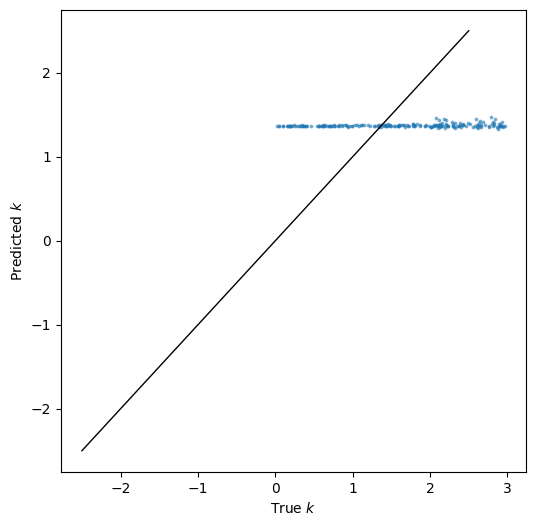

torch.Size([32, 1000, 2])
tensor([ 0.3139,  0.0404,  0.1574,  0.7773,  0.2620,  0.1018, -0.4987,  0.1523,
        -0.4385, -0.7195, -0.2126,  0.1468, -0.3381, -0.2846,  0.4282, -0.2398,
        -0.1746,  0.4777, -0.1835,  0.3001,  0.5047,  0.0180,  0.0009,  0.3743,
         0.1522, -0.2935,  0.5473, -0.2820, -0.6464,  0.3698,  0.4622, -0.0782])
torch.Size([32, 10, 3])


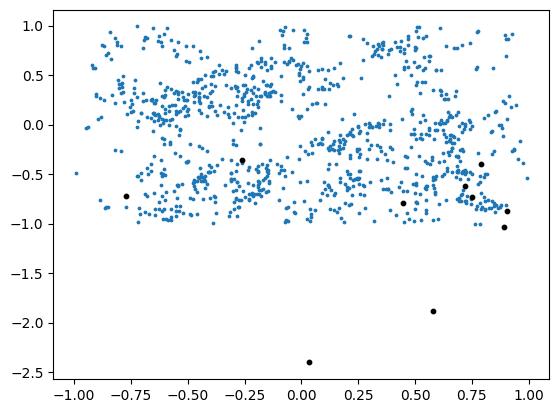

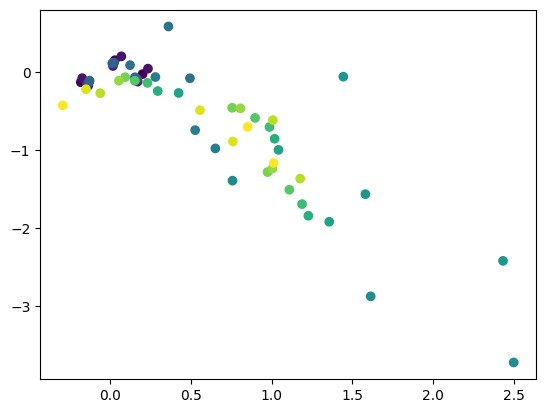

In [10]:
def show_predictions(model, dataloader):
    model.eval()
    with torch.no_grad():
        targs = []
        preds = []
        for i, (data, target) in enumerate(dataloader):
            data = data.to(device)
            output = model(data)
            targs.append(target.flatten())
            preds.append(output.cpu().flatten())
        targs = torch.cat(targs, dim=0)
        preds = torch.cat(preds, dim=0)

        print(np.sqrt(criterion(targs, preds).item()))

        plt.figure(figsize=(6, 6))
        plt.scatter(targs, preds, alpha=0.5, s=3)
        # Define the x values for the lines
        x = np.linspace(-2.5, 2.5)

        # Define the y values for each line
        y1 = x
        y2 = x + 0.1
        y3 = x - 0.1

        plt.plot(x, y1, c='black', linewidth=1)
        # plt.xlim(-0.1, 1.1)
        # plt.ylim(-0.1, 1.1)
        plt.xlabel('True $k$')
        plt.ylabel('Predicted $k$')
        plt.show()

def show_anchor_points(model, dataloader):
    model.eval()
    with torch.no_grad():
        for i, (data, target) in enumerate(dataloader):
            data = data.to(device)
            print(data.shape)
            print(model.pcn.anchor_selector.embedder(data).cpu().detach()[0])
            anchors = model.pcn.anchor_selector(data).cpu().detach()
            print(anchors.shape)
            data = data.cpu().detach()
            plt.scatter(data[0, :, 0], data[0, :, 1], s=3)
            plt.scatter(anchors[0, :, 0], anchors[0, :, 1], c='black', s=10)
            plt.show()
            break
    plt.show()


def show_test_results(test_results):
    test_results = torch.stack(test_results)
    for i in range(test_result.shape[1]):
        plt.scatter(test_results[:, i, 0], test_results[:, i, 1], c=np.linspace(0, 1, test_results.shape[0]))
    plt.show()

show_predictions(model, val_dataloader)
show_anchor_points(model, val_dataloader)
show_test_results(test_results)
